In [47]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import wandb
from pathlib import Path

In [48]:
api = wandb.Api()

entity = "justin_yang-university-of-california-berkeley"
project = "cs182-project-GPT-opt"
sweep_id = "5pllqyjx" # phase1-safetyfactor

sweep = api.sweep(f"{entity}/{project}/{sweep_id}")

In [4]:
for run in sweep.runs:
    print(f"Run ID: {run.id}")
    # print("---------- CONFIG ----------")
    # print("Safety Factor:", run.config["optimizer_params"]["args"]["polar_safety"])
    # for key in run.config.keys():
    #     print(key + ":", run.config[key])
    # print(run.summary["svd/update_layer0_v/condition_number"])
    # print("---------- SUMMARY ----------")
    # for key in run.summary.keys():
    #     print(key + ":", run.summary[key])
    # print("---------- HISTORY ----------")
    # for step in run.scan_history():
    #     # print(step["svd/update_layer0_stacked/condition_number"])
    #     for key in step.keys():
    #         print(key)
    #     break
    # break

Run ID: ud9tmam7
Run ID: pgavu9tw
Run ID: oso9lime
Run ID: ly4ms4uh
Run ID: zh36wbcn
Run ID: exhbqbum


In [49]:
def get_data(sweep_id, optimizer_param_name, optimizer_param_vals, update, layer, matrix, metric):

    if update:
        update = "update_"
    else:
        update = ""

    entity = "justin_yang-university-of-california-berkeley"
    project = "cs182-project-GPT-opt"

    api = wandb.Api()
    sweep = api.sweep(f"{entity}/{project}/{sweep_id}")

    data = {val: [] for val in optimizer_param_vals}

    for run in sweep.runs:
        run_id = run.id
        run_param = run.config["optimizer_params"]["args"][optimizer_param_name]

        data[run_param].append(np.array([step[f"svd/{update}layer{layer}_{matrix}/{metric}"] for step in run.scan_history()]))

    return data

In [162]:
def plot_data(sweep_id, param_name, param_id, param_vals, \
              update, layer, matrix, metric, start, end, \
              use_ci=False, log_scale=False, plot_med=True, save_plot=False):

    print("Getting Data...")
    data = get_data(sweep_id, param_id, param_vals, update, layer, matrix, metric)

    if update:
        update = "update_"
    else:
        update = ""

    df = {}
    for val in [1, 1.01]:
    
        arrays = data[val]
        valid_mask = arrays[0] != None
        steps = np.where(valid_mask)[0]
        valid_arrays = [x[valid_mask] for x in arrays]
        valid_arrays = np.asarray(valid_arrays, dtype=float)

        if use_ci:
            med_vec = np.mean(np.stack(valid_arrays), axis=0)
            std_vec = np.std(np.stack(valid_arrays), axis=0)
            N = np.stack(valid_arrays).shape[0]
            sem_vec = std_vec / np.sqrt(N)
            min_vec = med_vec - 1.96 * sem_vec
            max_vec = med_vec + 1.96 * sem_vec
        else:
            med_vec = np.median(np.stack(valid_arrays), axis=0)
            min_vec = np.min(np.stack(valid_arrays), axis=0)
            max_vec = np.max(np.stack(valid_arrays), axis=0)
    
        med_vec = np.asarray(med_vec, dtype=float)
        min_vec = np.asarray(min_vec, dtype=float)
        max_vec = np.asarray(max_vec, dtype=float)
    
        df[f"med_vec_{val}"] = med_vec
        df[f"min_vec_{val}"] = min_vec
        df[f"max_vec_{val}"] = max_vec

        if log_scale:
            df[f"med_vec_{val}"] = np.log(med_vec)
            df[f"min_vec_{val}"] = np.log(min_vec)
            df[f"max_vec_{val}"] = np.log(max_vec)
    
    df["Step"] = steps
    df = pd.DataFrame(df)
    df_iloc = df.iloc[start:end+1]

    print("Plotting Data...")
    sns.set_style("whitegrid")
    for val in [1, 1.01]:
        if plot_med:
            sns.lineplot(data=df_iloc, x="Step", y=f"med_vec_{val}")
        steps = df_iloc["Step"]
        min_vec = df_iloc[f"min_vec_{val}"]
        max_vec = df_iloc[f"max_vec_{val}"]
        plt.fill_between(steps, min_vec, max_vec, alpha=0.3, label=f"{val}");

    plt.title(f"{update.replace("_", "").title()} Layer {layer} {matrix.title()} - {metric.replace("_", " ").title()}")
    plt.xlabel("Step")
    if log_scale:
        plt.ylabel(f"{metric.replace("_", " ").title()} (Log Scale)")
    else:
        plt.ylabel(f"{metric.replace("_", " ").title()}")
    plt.legend(title = param_name)
    
    if save_plot:
        print("Plot Saved.")
        plt.savefig(f"./plots/{param_id}/{metric}/{update}layer{layer}_{matrix}_{metric}_{param_id}.jpg")
    
    plt.show();

In [ ]:
sweep_id = "5pllqyjx"
param_name = "Safety Factor"
param_id = "polar_safety"
param_vals = [1, 1.01]
update = True
layer = 0
matrix = "stacked"
metric = "condition_number"
start = 2
end = 32
use_ci = True
log_scale = True
plot_med = False
save_plot = True

plot_data(sweep_id, param_name, param_id, param_vals, update, layer, matrix, metric, start, end, use_ci, log_scale, plot_med, save_plot)

In [163]:
def download_all_plot_data(
    layers=(0, 5, 11),
    categories=ATTN_CATEGORIES,
    sweep_ids=VARIANT_SWEEP_IDS,
):
    """Download and cache all data needed for plotting.

    This hits W&B once to pull:
    - Attention entropy metrics for each (category, layer) pair.
    - Train/val loss by optimizer variant for the configured sweeps.
    - Train/loss per learning rate for each attention category's sweeps.

    Results are saved under plotting/cache/ as pickled DataFrames, and
    subsequent plotting calls (plot_all_layers, plot_all_variants_from_sweeps,
    plot_train_loss_for_attn_category) will load from these caches instead of
    re-querying W&B.
    """
    PLOTTING_CACHE_DIR.mkdir(parents=True, exist_ok=True)

    # Attention entropy caches
    for category_name, ids in categories.items():
        for layer in layers:
            print(f"[download] attn entropy for {category_name}, layer {layer}...")
            df = get_attn_entropy_for_ids(ids, layer)
            if df.empty:
                print("  (no data)")
                continue
            path = _attn_cache_path(category_name, layer)
            df.to_pickle(path)
            print(f"  saved to {path}")

    # Variant loss caches (optimizer variants sweep)
    for metric_key in ("train/loss", "val/loss"):
        print(f"[download] {metric_key} for optimizer variants...")
        df = get_loss_by_variant(metric_key, sweep_ids=sweep_ids)
        if df.empty:
            print("  (no data)")
            continue
        path = _variant_cache_path(metric_key, sweep_ids)
        df.to_pickle(path)
        print(f"  saved to {path}")

    # Train loss caches for attention categories (per LR)
    for category_name, ids in categories.items():
        print(f"[download] train/loss for {category_name} (attn sweeps)...")
        df = get_train_loss_for_attn_category(category_name, ids=ids)
        if df.empty:
            print("  (no data)")
            continue
        path = _train_loss_cache_path_for_category(category_name)
        df.to_pickle(path)
        print(f"  saved to {path}")

    print("Done. Future plotting calls will use cached data unless use_cache=False.")

In [ ]:
ENTITY = "justin_yang-university-of-california-berkeley"
PROJECT = "cs182-project-GPT-opt"

# Local cache directory for plotting data (ignored by git)
PLOTTING_CACHE_DIR = Path("plotting") / "cache"
PLOTTING_CACHE_DIR.mkdir(parents=True, exist_ok=True)

# Map high-level optimizer categories to sweep IDs or run IDs.
ATTN_CATEGORIES = {
    "AdamW": ["pxrm9xt8", "hkw05gba", "eifb7cyl", "4uytpec5"],
    "Muon-NS-All": ["qmzevjll", "lh2tzeh1", "capygls4"],
    "Muon-NS-VOFFN": ["88vr9lps"],
    "Muon-PE-All": ["emzbw2qc", "q02rln6i"],
    "Muon-PE-VOFFN": ["67g7mm51"],
}

# Nicer titles for figure headers
ATTN_CATEGORY_TITLES = {
    "AdamW": "AdamW",
    "Muon-NS-All": "Muon Newton-Schulz (QKV, O, FFN)",
    "Muon-NS-VOFFN": "Muon Newton-Schulz (V, O, FFN)",
    "Muon-PE-All": "Muon Polar Express (QKV, O, FFN)",
    "Muon-PE-VOFFN": "Muon Polar Express (V, O, FFN)",
}

# Fixed y-axis range for all attention entropy plots
DEFAULT_YLIM = (0.0, 6.0)

# Use epoch fraction on x-axis instead of raw step
USE_EPOCH_X = True
EPOCH_MAX = 0.3  # runs are 0.3 epochs


def _collect_runs_for_ids(ids, entity=ENTITY, project=PROJECT):
    """Given a list of sweep IDs and/or run IDs, return a flat list of runs."""
    api = wandb.Api()
    runs = []
    for _id in ids:
        # Try treating as a sweep ID first
        try:
            sweep = api.sweep(f"{entity}/{project}/{_id}")
            runs.extend(list(sweep.runs))
            continue
        except Exception:
            pass
        # Fallback: single run ID
        try:
            run = api.run(f"{entity}/{project}/{_id}")
            runs.append(run)
        except Exception as e:
            print(f"Warning: could not load sweep or run '{_id}': {e}")
    return runs


def _attn_cache_path(category_name, layer):
    safe_cat = str(category_name).replace("/", "_")
    return PLOTTING_CACHE_DIR / f"attn_{safe_cat}_layer{layer}.pkl"


def _load_attn_cache(category_name, layer):
    path = _attn_cache_path(category_name, layer)
    if path.exists():
        try:
            return pd.read_pickle(path)
        except Exception as e:
            print(f"Warning: failed to read attention cache {path}: {e}")
    return None


def _save_attn_cache(category_name, layer, df):
    path = _attn_cache_path(category_name, layer)
    try:
        df.to_pickle(path)
    except Exception as e:
        print(f"Warning: failed to write attention cache {path}: {e}")


def get_attn_entropy_for_ids(ids, layer, entity=ENTITY, project=PROJECT):
    """Aggregate attn/layer{layer}/entropy/mean across runs.

    Returns a DataFrame with columns: lr, step, mean, std, sem, n.
    """
    metric_key = f"attn/layer{layer}/entropy/mean"
    runs = _collect_runs_for_ids(ids, entity=entity, project=project)
    records = []

    for run in runs:
        # Try nested sweep config, then flat key
        lr = None
        try:
            lr = run.config["optimizer_params"]["args"]["lr"]
        except Exception:
            lr = run.config.get("optimizer_params.args.lr", None)
        if lr is None:
            continue

        for row in run.scan_history():
            if metric_key not in row:
                continue
            val = row[metric_key]
            step = row.get("_step", None)
            if step is None or val is None:
                continue
            records.append(
                {
                    "lr": float(lr),
                    "step": int(step),
                    "value": float(val),
                    "run_id": run.id,
                }
            )

    if not records:
        return pd.DataFrame(columns=["lr", "step", "mean", "std", "sem", "n"])

    df = pd.DataFrame(records)
    grouped = (
        df.groupby(["lr", "step"])["value"]
        .agg(["mean", "std", "count"])
        .reset_index()
        .rename(columns={"count": "n"})
    )
    grouped["sem"] = grouped["std"] / np.sqrt(grouped["n"].clip(lower=1))
    grouped = grouped.sort_values(["lr", "step"])
    return grouped


def plot_attn_entropy_category(
    category_name,
    ids,
    layer,
    ax=None,
    ylim=DEFAULT_YLIM,
    add_legend=True,
    use_epoch_x=USE_EPOCH_X,
    epoch_max=EPOCH_MAX,
    use_cache=True,
    lr_min=None,
    lr_max=None,
    print_end_stats=True,
):
    """Plot mean line + SEM band for a category (set of sweeps/runs) for one layer.

    If use_cache is True (default), try to read a cached DataFrame for this
    (category, layer) combination from disk; if missing, download from W&B
    once, cache it, and then plot.

    lr_min / lr_max: if provided, restrict curves to learning rates within
    [lr_min, lr_max].

    print_end_stats: if True, print for each learning rate the final mean and
    (mean ± SEM) at the last logged step.
    """
    df = _load_attn_cache(category_name, layer) if use_cache else None
    if df is None:
        df = get_attn_entropy_for_ids(ids, layer)
        if use_cache and not df.empty:
            _save_attn_cache(category_name, layer, df)

    # For AdamW, drop very large learning rates to focus on the main range
    if category_name == "AdamW" and not df.empty:
        df = df[df["lr"] <= 0.0024 + 1e-12]

    # Optional LR filtering
    if lr_min is not None:
        df = df[df["lr"] >= lr_min]
    if lr_max is not None:
        df = df[df["lr"] <= lr_max]

    if df.empty:
        print(f"No data found for {category_name}, layer {layer} after LR filtering.")
        return

    if ax is None:
        fig, ax = plt.subplots(figsize=(7, 4))

    sns.set_style("whitegrid")

    # Normalize steps so that the earliest diagnostic log maps to epoch 0
    min_step = df["step"].min() if not df.empty else 0
    max_step = df["step"].max() if not df.empty else 0
    span = max(max_step - min_step, 1)

    for lr, sub in df.groupby("lr"):
        sub = sub.sort_values("step")
        steps = sub["step"].values.astype(float)
        mean_vals = sub["mean"].values
        sem_vals = sub["sem"].fillna(0.0).values

        if use_epoch_x:
            x_vals = (steps - min_step) / span * (epoch_max if epoch_max is not None else 1.0)
        else:
            x_vals = steps

        ax.plot(x_vals, mean_vals, label=f"{lr:g}")
        ax.fill_between(x_vals, mean_vals - sem_vals, mean_vals + sem_vals, alpha=0.25)

        # Optionally print final mean and error-bar bounds for this learning rate
        if print_end_stats and len(mean_vals) > 0:
            final_mean = float(mean_vals[-1])
            final_sem = float(sem_vals[-1])
            lower = final_mean - final_sem
            upper = final_mean + final_sem
            print(
                f"{category_name}, layer {layer}, lr={lr:g}: "
                f"final mean={final_mean:.4f}, lower={lower:.4f}, upper={upper:.4f}"
            )

    title_base = ATTN_CATEGORY_TITLES.get(category_name, category_name)
    ax.set_title(f"Layer {layer} Attention Entropy for {title_base}", pad=14)
    ax.set_ylabel("Mean Entropy")
    if ylim is not None:
        ax.set_ylim(*ylim)

    # X-axis labeling
    if use_epoch_x:
        ax.set_xlabel("Epoch")
        if epoch_max is not None:
            ax.set_xlim(0.0, epoch_max)
    else:
        ax.set_xlabel("Step")
        ax.set_xlim(left=0.0)

    # Ensure y-axis tick labels are visible on all subplots
    ax.tick_params(axis="y", labelleft=True)

    if add_legend:
        ax.legend(title="Learning Rate", fontsize=8)

    return ax


def plot_layers_for_category(
    category_name,
    layers=(0, 5, 11),
    categories=ATTN_CATEGORIES,
    ylim=DEFAULT_YLIM,
    use_epoch_x=USE_EPOCH_X,
    epoch_max=EPOCH_MAX,
    use_cache=True,
    lr_min=None,
    lr_max=None,
    print_end_stats=True,
):
    """For a single category, make one figure with subplots (3 in a row by default)."""
    ids = categories[category_name]
    n_layers = len(layers)
    fig, axes = plt.subplots(1, n_layers, figsize=(5 * n_layers, 4), sharey=True)
    if n_layers == 1:
        axes = [axes]

    # First axis gets a legend so we can harvest handles/labels
    for i, (ax, layer) in enumerate(zip(axes, layers)):
        add_legend = (i == 0)
        plot_attn_entropy_category(
            category_name,
            ids,
            layer,
            ax=ax,
            ylim=ylim,
            add_legend=add_legend,
            use_epoch_x=use_epoch_x,
            epoch_max=epoch_max,
            use_cache=use_cache,
            lr_min=lr_min,
            lr_max=lr_max,
            print_end_stats=print_end_stats,
        )

    # Build a single shared legend from the first axis, then remove per-axis legend
    handles, labels = axes[0].get_legend_handles_labels()
    if axes[0].get_legend() is not None:
        axes[0].get_legend().remove()

    fig.legend(
        handles,
        labels,
        title="Learning Rate",
        loc="upper center",
        bbox_to_anchor=(0.5, 1.08),
        ncol=min(4, len(labels)),
        fontsize=8,
    )
    fig.suptitle(ATTN_CATEGORY_TITLES.get(category_name, category_name), y=1.16)
    fig.tight_layout(rect=(0, 0, 1, 0.93))
    plt.show()

    return fig, axes


def plot_all_layers(
    layers=(0, 5, 11),
    categories=ATTN_CATEGORIES,
    ylim=DEFAULT_YLIM,
    use_epoch_x=USE_EPOCH_X,
    epoch_max=EPOCH_MAX,
    use_cache=True,
    lr_min=None,
    lr_max=None,
    print_end_stats=True,
):
    """For each category, produce one figure with |layers| subplots (side by side)."""
    for name in categories.keys():
        plot_layers_for_category(
            name,
            layers=layers,
            categories=categories,
            ylim=ylim,
            use_epoch_x=use_epoch_x,
            epoch_max=epoch_max,
            use_cache=use_cache,
            lr_min=lr_min,
            lr_max=lr_max,
            print_end_stats=print_end_stats,
        )

In [168]:
# ---- Layout knobs for combined attention figure ----
# You can tweak these values and re-run this cell if titles/legends
# look slightly misaligned in your environment.
COMBINED_LEGEND_Y = 1.08     # vertical anchor for LR legend (relative to top axis)
COMBINED_SUBTITLE_Y = 0.81   # y-position for optimizer names (figure coords)
COMBINED_TITLE_Y = 0.87      # y-position for main title (figure coords)
COMBINED_TIGHT_RECT = (0, 0, 1, 0.86)  # reserved top band for titles/legends

# Optional small horizontal nudges for each optimizer subtitle (figure coords).
# Positive values move the label to the right, negative to the left.
# Typical magnitudes are around +/- 0.005 or 0.01.
COMBINED_SUBTITLE_X_NUDGE = {
    "AdamW": -0.07,
    "Muon-NS-All": -0.03,
    "Muon-PE-All": 0,
    "Muon-NS-VOFFN": 0.03,
    "Muon-PE-VOFFN": 0.07,
}


def plot_all_categories_combined(
    categories_order=("AdamW", "Muon-NS-All", "Muon-PE-All", "Muon-NS-VOFFN", "Muon-PE-VOFFN"),
    layers=(0, 5, 11),
    categories=ATTN_CATEGORIES,
    ylim=DEFAULT_YLIM,
    use_epoch_x=USE_EPOCH_X,
    epoch_max=EPOCH_MAX,
    use_cache=True,
    # Global LR filters (fallback/default)
    lr_min=None,
    lr_max=None,
    # Optional per-category LR ranges: {"AdamW": (min, max), ...}
    lr_ranges_by_category=None,
    # Kept for API compatibility; currently unused in this variant.
    base_lr_by_category=None,
    print_end_stats=False,
):
    """Make a single combined figure of attention entropy across all categories.

    Layout: rows = layers (e.g., 0, 5, 11), columns = optimizer categories
    (AdamW, Muon-NS-All, Muon-PE-All, Muon-NS-VOFFN, Muon-PE-VOFFN).

    Each axis is produced by `plot_attn_entropy_category`, but we:
    - share x/y axes across the grid,
    - place a *legend with raw LR values* just above each optimizer column
      (attached to the top-row subplot for that column, but outside the
       plotting area),
    - render the optimizer name as a subtitle above the LR legend, and
    - clean up per-axis labels so the result is paper-friendly.

    If the placement of legends/titles looks off, edit the COMBINED_*
    knobs at the top of this cell (including COMBINED_SUBTITLE_X_NUDGE)
    and re-run it.

    LR filtering behavior:
    - If `lr_ranges_by_category` is provided and contains an entry for a
      category, that (min, max) is used for that category.
    - Otherwise, the global `lr_min` / `lr_max` values are used.
    """
    n_rows = len(layers)
    n_cols = len(categories_order)

    fig_width = 3 * n_cols
    fig_height = 3 * n_rows
    fig, axes = plt.subplots(
        n_rows,
        n_cols,
        figsize=(fig_width, fig_height),
        sharex=True,
        sharey=True,
    )

    # Ensure 2D indexing even if n_rows or n_cols is 1
    if n_rows == 1:
        axes = np.array([axes])
    if n_cols == 1:
        axes = axes.reshape(n_rows, 1)

    # First pass: draw all curves without legends; basic labels only
    for col, category_name in enumerate(categories_order):
        if category_name not in categories:
            print(f"Warning: category '{category_name}' not found in ATTN_CATEGORIES; skipping.")
            continue
        ids = categories[category_name]

        # Determine LR range for this category
        cat_lr_min, cat_lr_max = lr_min, lr_max
        if lr_ranges_by_category is not None:
            rng = lr_ranges_by_category.get(category_name)
            if rng is not None:
                # Allow specifying None for one side if desired
                if len(rng) != 2:
                    raise ValueError(
                        f"lr_ranges_by_category['{category_name}'] must be a (min, max) tuple, got {rng!r}"
                    )
                cat_lr_min, cat_lr_max = rng

        for row, layer in enumerate(layers):
            ax = axes[row, col]

            # No internal legends; we'll attach a legend just above the
            # top-row axis for each column.
            add_legend = False

            plot_attn_entropy_category(
                category_name,
                ids,
                layer,
                ax=ax,
                ylim=ylim,
                add_legend=add_legend,
                use_epoch_x=use_epoch_x,
                epoch_max=epoch_max,
                use_cache=use_cache,
                lr_min=cat_lr_min,
                lr_max=cat_lr_max,
                print_end_stats=print_end_stats,
            )

            # Remove per-axis titles; we'll render optimizer names as
            # separate subtitles above the legends.
            ax.set_title("")

            if col == 0:
                # Leftmost column: label rows by layer
                ax.set_ylabel(f"Layer {layer}\nMean Entropy")
            else:
                ax.set_ylabel("")

            # Only bottom row keeps the x-axis label; others drop it
            if row < n_rows - 1:
                ax.set_xlabel("")

    # Second pass: per-column legends with raw LR values, placed just above each optimizer
    for col, category_name in enumerate(categories_order):
        if category_name not in categories:
            continue
        top_ax = axes[0, col]

        # Collect unique LR labels from the top axis' line objects
        lines = top_ax.get_lines()
        if not lines:
            continue

        lr_vals = []
        line_by_lr = {}
        for ln in lines:
            lab = ln.get_label()
            try:
                lr_val = float(lab)
            except (TypeError, ValueError):
                continue
            lr_vals.append(lr_val)
            # Keep one representative line handle per LR
            if lr_val not in line_by_lr:
                line_by_lr[lr_val] = ln

        lr_vals = sorted(set(lr_vals))
        if not lr_vals:
            continue

        handles = [line_by_lr[v] for v in lr_vals]
        labels = [f"{v:g}" for v in lr_vals]

        top_ax.legend(
            handles,
            labels,
            title="LR",
            loc="lower center",
            bbox_to_anchor=(0.5, COMBINED_LEGEND_Y),
            ncol=min(len(labels), 3),
            fontsize=8,
            borderaxespad=0.0,
        )

    # Column subtitles (optimizer names) above the LR legends, centered over each column,
    # with an optional small horizontal nudge per category.
    for col, category_name in enumerate(categories_order):
        if category_name not in categories:
            continue
        title_base = ATTN_CATEGORY_TITLES.get(category_name, category_name)

        top_ax = axes[0, col]
        bbox = top_ax.get_position()  # in figure coordinates
        x_center = 0.5 * (bbox.x0 + bbox.x1)
        x_nudge = COMBINED_SUBTITLE_X_NUDGE.get(category_name, 0.0)
        x = x_center + x_nudge

        fig.text(
            x,
            COMBINED_SUBTITLE_Y,
            title_base,
            ha="center",
            va="bottom",
            fontsize=10,
        )

    # No global x-axis label; rely on per-subplot labels on the bottom row
    if use_epoch_x:
        if epoch_max is not None:
            for ax in axes[-1, :]:
                ax.set_xlim(0.0, epoch_max)
    else:
        for ax in axes[-1, :]:
            ax.set_xlim(left=0.0)

    # Larger, bold main title, placed above subtitles
    fig.suptitle(
        "Attention Entropy vs Epoch for GPT-2 Small (Layers 0, 5, 11 across Optimizers)",
        y=COMBINED_TITLE_Y,
        fontsize=16,
        fontweight="bold",
    )

    fig.tight_layout(rect=COMBINED_TIGHT_RECT)
    plt.show()

    return fig, axes

In [159]:
# Variant-based plots for sweeps vqkcitxv (Muon variants) and ov703ihc (AdamW)

VARIANT_SWEEP_IDS = ["vqkcitxv", "ov703ihc"]

# Map raw muon_variant strings to concise display names
VARIANT_TITLE_MAP = {
    "pe_all": "Muon PE (all matrices)",
    "ns_all": "Muon NS (all matrices)",
    "pe_voffn": "Muon PE (V, O, FFN)",
    "ns_voffn": "Muon NS (V, O, FFN)",
    "pe_mod_all": "Muon PE-mod (all matrices)",
    "adamw": "AdamW",
}

# Canonical display-order for variants so colors stay fixed even if we filter
CANONICAL_VARIANTS = [
    "AdamW",
    "Muon NS (V, O, FFN)",
    "Muon NS (all matrices)",
    "Muon PE (V, O, FFN)",
    "Muon PE (all matrices)",
    "Muon PE-mod (all matrices)",
]


def _collect_variant_runs(sweep_ids=VARIANT_SWEEP_IDS, entity=ENTITY, project=PROJECT):
    api = wandb.Api()
    runs = []
    for sid in sweep_ids:
        try:
            sweep = api.sweep(f"{entity}/{project}/{sid}")
            runs.extend(list(sweep.runs))
        except Exception as e:
            print(f"Warning: could not load sweep '{sid}': {e}")
    return runs


def _get_variant_label(cfg):
    """Infer optimizer variant label from run config.

    - Prefer nested optimizer_params.args.muon_variant.
    - Fall back to flattened key optimizer_params.args.muon_variant.
    - Otherwise, treat as AdamW.
    """
    raw_variant = None

    # Nested form
    try:
        raw_variant = cfg["optimizer_params"]["args"].get("muon_variant")
    except Exception:
        pass

    # Flattened form
    if raw_variant is None:
        raw_variant = cfg.get("optimizer_params.args.muon_variant")

    if raw_variant is None:
        raw_variant = "adamw"

    return VARIANT_TITLE_MAP.get(raw_variant, raw_variant)


def _variant_cache_path(metric_key, sweep_ids):
    safe_metric = metric_key.replace("/", "_")
    sid_part = "_".join(sorted(sweep_ids))
    return PLOTTING_CACHE_DIR / f"variants_{safe_metric}_{sid_part}.pkl"


def _load_variant_cache(metric_key, sweep_ids):
    path = _variant_cache_path(metric_key, sweep_ids)
    if path.exists():
        try:
            return pd.read_pickle(path)
        except Exception as e:
            print(f"Warning: failed to read variant cache {path}: {e}")
    return None


def _save_variant_cache(metric_key, sweep_ids, df):
    path = _variant_cache_path(metric_key, sweep_ids)
    try:
        df.to_pickle(path)
    except Exception as e:
        print(f"Warning: failed to write variant cache {path}: {e}")


def get_loss_by_variant(metric_key, sweep_ids=VARIANT_SWEEP_IDS, entity=ENTITY, project=PROJECT):
    """Aggregate a scalar metric (e.g. train/loss) grouped by (variant, step).

    - metric_key: e.g. "train/loss" or "val/loss".
    - Uses `_step` if present; otherwise falls back to `epoch` or row index.
    """
    runs = _collect_variant_runs(sweep_ids=sweep_ids, entity=entity, project=project)
    records = []

    for run in runs:
        cfg = run.config
        variant = _get_variant_label(cfg)

        for i, row in enumerate(run.scan_history()):
            if metric_key not in row:
                continue
            val = row[metric_key]
            # Prefer W&B internal step; fall back to logged epoch or index
            step = row.get("_step")
            if step is None:
                step = row.get("epoch")
            if step is None:
                step = i
            if val is None:
                continue
            records.append(
                {
                    "variant": variant,
                    "step": float(step),
                    "value": float(val),
                    "run_id": run.id,
                }
            )

    if not records:
        print(f"{metric_key}: no records found in sweeps {sweep_ids}")
        return pd.DataFrame(columns=["variant", "step", "mean", "std", "sem", "n"])

    df = pd.DataFrame(records)
    grouped = (
        df.groupby(["variant", "step"])["value"]
        .agg(["mean", "std", "count"])
        .reset_index()
        .rename(columns={"count": "n"})
    )
    grouped["sem"] = grouped["std"] / np.sqrt(grouped["n"].clip(lower=1))
    grouped = grouped.sort_values(["variant", "step"])

    print(f"{metric_key}: found variants {sorted(grouped['variant'].unique())}")
    return grouped


def plot_all_variants_from_sweeps(
    sweep_ids=VARIANT_SWEEP_IDS,
    use_epoch_x=USE_EPOCH_X,
    epoch_max=EPOCH_MAX,
    epoch_window=None,
    include_adamw=True,
    use_cache=True,
):
    """Plot train/loss and val/loss vs epoch with one line per optimizer variant.

    Left subplot: train/loss; Right subplot: val/loss.
    Legend: optimizer variant.

    Behavior:
    - If `epoch_window` is None: plot the full run in the simple "normal" way
      (one pass, line + SEM band, no interpolation, no custom y-limits).
    - If `epoch_window` is provided and `use_epoch_x` is True: use two-pass
      logic (full curve for context + highlighted window segment) and
      interpolate values at the window boundaries so both the line and SEM
      reach the axis edges.
    - If `include_adamw` is False, drop the AdamW curve(s) entirely.
    - If `use_cache` is True (default), read/write variant aggregates from
      disk so we do not hit W&B on every plotting call.
    """
    # Aggregate metrics (possibly from cache)
    if use_cache:
        train_df = _load_variant_cache("train/loss", sweep_ids)
        val_df = _load_variant_cache("val/loss", sweep_ids)
        if train_df is None:
            train_df = get_loss_by_variant("train/loss", sweep_ids=sweep_ids)
            _save_variant_cache("train/loss", sweep_ids, train_df)
        if val_df is None:
            val_df = get_loss_by_variant("val/loss", sweep_ids=sweep_ids)
            _save_variant_cache("val/loss", sweep_ids, val_df)
    else:
        train_df = get_loss_by_variant("train/loss", sweep_ids=sweep_ids)
        val_df = get_loss_by_variant("val/loss", sweep_ids=sweep_ids)

    # Optional filtering of AdamW
    if not include_adamw:
        if not train_df.empty:
            train_df = train_df[train_df["variant"] != "AdamW"]
        if not val_df.empty:
            val_df = val_df[val_df["variant"] != "AdamW"]

    if train_df.empty and val_df.empty:
        print("No loss data found for the specified sweeps after filtering.")
        return

    # Set of all variants appearing in either metric
    variants = set()
    if not train_df.empty:
        variants.update(train_df["variant"].unique())
    if not val_df.empty:
        variants.update(val_df["variant"].unique())
    variants = [v for v in CANONICAL_VARIANTS if v in variants]

    if not variants:
        print("No variants to plot after filtering.")
        return

    # Fixed color map so variants have consistent colors across subplots
    palette = sns.color_palette(n_colors=len(CANONICAL_VARIANTS))
    color_map = {name: palette[i] for i, name in enumerate(CANONICAL_VARIANTS)}

    fig, axes = plt.subplots(1, 2, figsize=(10, 4), sharex=True)
    ax_train, ax_val = axes

    # --------- Case 1: full-run view (no window) ---------
    if epoch_window is None or not use_epoch_x:

        def _plot_metric(df, ax, ylabel):
            if df.empty:
                ax.set_visible(False)
                return

            sns.set_style("whitegrid")

            min_step = df["step"].min() if not df.empty else 0.0
            max_step = df["step"].max() if not df.empty else 0.0
            span = max(max_step - min_step, 1e-8)

            for variant in variants:
                sub = df[df["variant"] == variant]
                if sub.empty:
                    continue
                sub = sub.sort_values("step")
                steps = sub["step"].values.astype(float)
                mean_vals = sub["mean"].values
                sem_vals = sub["sem"].fillna(0.0).values

                if use_epoch_x:
                    x_vals = (steps - min_step) / span * (
                        epoch_max if epoch_max is not None else 1.0
                    )
                else:
                    x_vals = steps

                color = color_map.get(variant)

                ax.plot(x_vals, mean_vals, color=color, alpha=1.0, label=variant)
                ax.fill_between(
                    x_vals,
                    mean_vals - sem_vals,
                    mean_vals + sem_vals,
                    alpha=0.2,
                    color=color,
                )

            if use_epoch_x:
                ax.set_xlabel("Epoch")
                if epoch_max is not None:
                    ax.set_xlim(0.0, epoch_max)
            else:
                ax.set_xlabel("Step")
                ax.set_xlim(left=0.0)

            ax.set_ylabel(ylabel)
            ax.tick_params(axis="y", labelleft=True)

    # --------- Case 2: zoomed view with window ---------
    else:

        emin, emax = epoch_window

        def _plot_metric(df, ax, ylabel):
            if df.empty:
                ax.set_visible(False)
                return

            sns.set_style("whitegrid")

            # Compute epoch coordinate for all points once
            min_step = df["step"].min() if not df.empty else 0.0
            max_step = df["step"].max() if not df.empty else 0.0
            span = max(max_step - min_step, 1e-8)

            df_local = df.copy()
            df_local["epoch"] = (df_local["step"] - min_step) / span * (
                epoch_max if epoch_max is not None else 1.0
            )

            zoom_ymin, zoom_ymax = None, None

            for variant in variants:
                sub = df_local[df_local["variant"] == variant]
                if sub.empty:
                    continue
                sub = sub.sort_values("step")
                x_vals = sub["epoch"].values
                mean_vals = sub["mean"].values
                sem_vals = sub["sem"].fillna(0.0).values

                color = color_map.get(variant)

                # Full curve (will be clipped by xlim)
                ax.plot(x_vals, mean_vals, color=color, alpha=1.0)

                # Points strictly inside the window
                mask = (x_vals >= emin) & (x_vals <= emax)
                x_zoom = x_vals[mask]
                mean_zoom = mean_vals[mask]
                sem_zoom = sem_vals[mask]

                # Interpolate boundary points at emin and emax (if crossed)
                boundary_x = []
                boundary_mean = []
                boundary_sem = []
                if x_vals.size >= 2:
                    for b in (emin, emax):
                        j = np.searchsorted(x_vals, b)
                        if 0 < j < x_vals.size:
                            x0, x1 = x_vals[j - 1], x_vals[j]
                            if x1 == x0:
                                continue
                            t = (b - x0) / (x1 - x0)
                            m = mean_vals[j - 1] + t * (mean_vals[j] - mean_vals[j - 1])
                            s = sem_vals[j - 1] + t * (sem_vals[j] - sem_vals[j - 1])
                            boundary_x.append(b)
                            boundary_mean.append(m)
                            boundary_sem.append(s)

                if boundary_x:
                    x_ext = np.concatenate([x_zoom, np.array(boundary_x, dtype=float)])
                    mean_ext = np.concatenate([mean_zoom, np.array(boundary_mean, dtype=float)])
                    sem_ext = np.concatenate([sem_zoom, np.array(boundary_sem, dtype=float)])
                    order = np.argsort(x_ext)
                    x_zoom = x_ext[order]
                    mean_zoom = mean_ext[order]
                    sem_zoom = sem_ext[order]

                if x_zoom.size == 0:
                    continue

                # Highlight zoom segment + SEM, including boundary-interpolated points
                ax.plot(x_zoom, mean_zoom, color=color, alpha=1.0, label=variant)
                ax.fill_between(x_zoom, mean_zoom - sem_zoom, mean_zoom + sem_zoom, alpha=0.2, color=color)

                cur_min = float((mean_zoom - sem_zoom).min())
                cur_max = float((mean_zoom + sem_zoom).max())
                zoom_ymin = cur_min if zoom_ymin is None else min(zoom_ymin, cur_min)
                zoom_ymax = cur_max if zoom_ymax is None else max(zoom_ymax, cur_max)

            ax.set_xlabel("Epoch")
            ax.set_xlim(emin, emax)

            if zoom_ymin is not None and zoom_ymax is not None:
                pad = max(0.05 * (zoom_ymax - zoom_ymin), 0.02)
                ax.set_ylim(zoom_ymin - pad, zoom_ymax + pad)

            ax.set_ylabel(ylabel)
            ax.tick_params(axis="y", labelleft=True)

    # Call the appropriate plotting helper
    _plot_metric(train_df, ax_train, "Train Loss")
    _plot_metric(val_df, ax_val, "Val Loss")

    # Shared legend
    handles, labels = ax_train.get_legend_handles_labels()
    if ax_train.get_legend() is not None:
        ax_train.get_legend().remove()

    fig.legend(
        handles,
        labels,
        title="Optimizer Variant",
        loc="upper center",
        bbox_to_anchor=(0.5, 1.08),
        ncol=min(3, len(labels)),
        fontsize=8,
    )

    if epoch_window is None:
        title_suffix = "(full run)"
    else:
        title_suffix = f"(Epoch {epoch_window[0]:.2f}–{epoch_window[1]:.2f})"

    fig.suptitle(f"Train and Validation Loss by Optimizer Variant {title_suffix}", y=1.16)
    fig.tight_layout(rect=(0, 0, 1, 0.93))
    plt.show()

    return fig, axes

In [150]:
download_all_plot_data(layers=(0, 5, 11))

[download] attn entropy for AdamW, layer 0...
  saved to plotting/cache/attn_AdamW_layer0.pkl
[download] attn entropy for AdamW, layer 5...
  saved to plotting/cache/attn_AdamW_layer5.pkl
[download] attn entropy for AdamW, layer 11...
  saved to plotting/cache/attn_AdamW_layer11.pkl
[download] attn entropy for Muon-NS-All, layer 0...
  saved to plotting/cache/attn_Muon-NS-All_layer0.pkl
[download] attn entropy for Muon-NS-All, layer 5...
  saved to plotting/cache/attn_Muon-NS-All_layer5.pkl
[download] attn entropy for Muon-NS-All, layer 11...
  saved to plotting/cache/attn_Muon-NS-All_layer11.pkl
[download] attn entropy for Muon-NS-VOFFN, layer 0...
  saved to plotting/cache/attn_Muon-NS-VOFFN_layer0.pkl
[download] attn entropy for Muon-NS-VOFFN, layer 5...
  saved to plotting/cache/attn_Muon-NS-VOFFN_layer5.pkl
[download] attn entropy for Muon-NS-VOFFN, layer 11...
  saved to plotting/cache/attn_Muon-NS-VOFFN_layer11.pkl
[download] attn entropy for Muon-PE-All, layer 0...
  saved to p

In [173]:
def plot_full_and_zoomed_variants(
    sweep_ids=VARIANT_SWEEP_IDS,
    zoom_window=(0.95, 1.0),
    use_epoch_x=USE_EPOCH_X,
    epoch_max=EPOCH_MAX,
    use_cache=True,
):
    """Make a single figure with full-run and zoomed loss for all variants.

    Layout:
      - Top row:   full-train (left), full-val (right), includes AdamW.
      - Bottom row: zoomed-train (left), zoomed-val (right), AdamW removed.

    The zoomed view focuses on the final `zoom_window` in epoch space,
    e.g. (0.95, 1.0).
    """
    # Aggregate metrics (possibly from cache)
    if use_cache:
        train_df_full = _load_variant_cache("train/loss", sweep_ids)
        val_df_full = _load_variant_cache("val/loss", sweep_ids)
        if train_df_full is None:
            train_df_full = get_loss_by_variant("train/loss", sweep_ids=sweep_ids)
            _save_variant_cache("train/loss", sweep_ids, train_df_full)
        if val_df_full is None:
            val_df_full = get_loss_by_variant("val/loss", sweep_ids=sweep_ids)
            _save_variant_cache("val/loss", sweep_ids, val_df_full)
    else:
        train_df_full = get_loss_by_variant("train/loss", sweep_ids=sweep_ids)
        val_df_full = get_loss_by_variant("val/loss", sweep_ids=sweep_ids)

    if train_df_full.empty and val_df_full.empty:
        print("No loss data found for the specified sweeps.")
        return

    # For zoomed panels, drop AdamW so we only compare Muon variants
    train_df_zoom = train_df_full[train_df_full["variant"] != "AdamW"] if not train_df_full.empty else train_df_full
    val_df_zoom   = val_df_full[val_df_full["variant"] != "AdamW"]   if not val_df_full.empty   else val_df_full

    # Variant sets
    variants_full = set()
    if not train_df_full.empty:
        variants_full.update(train_df_full["variant"].unique())
    if not val_df_full.empty:
        variants_full.update(val_df_full["variant"].unique())
    variants_full = [v for v in CANONICAL_VARIANTS if v in variants_full]

    variants_zoom = set()
    if not train_df_zoom.empty:
        variants_zoom.update(train_df_zoom["variant"].unique())
    if not val_df_zoom.empty:
        variants_zoom.update(val_df_zoom["variant"].unique())
    variants_zoom = [v for v in CANONICAL_VARIANTS if v in variants_zoom]

    if not variants_full:
        print("No variants to plot after filtering.")
        return

    palette = sns.color_palette(n_colors=len(CANONICAL_VARIANTS))
    color_map = {name: palette[i] for i, name in enumerate(CANONICAL_VARIANTS)}

    # NOTE: we intentionally do NOT share x across rows, so that the
    # top row can show the full epoch range [0, 1] while the bottom row
    # shows only the zoomed window [zoom_window[0], zoom_window[1]].
    fig, axes = plt.subplots(2, 2, figsize=(10, 8))
    ax_train_full, ax_val_full = axes[0]
    ax_train_zoom, ax_val_zoom = axes[1]

    def _plot_full(df, ax, ylabel):
        if df.empty:
            ax.set_visible(False)
            return

        sns.set_style("whitegrid")

        min_step = df["step"].min() if not df.empty else 0.0
        max_step = df["step"].max() if not df.empty else 0.0
        span = max(max_step - min_step, 1e-8)

        for variant in variants_full:
            sub = df[df["variant"] == variant]
            if sub.empty:
                continue
            sub = sub.sort_values("step")
            steps = sub["step"].values.astype(float)
            mean_vals = sub["mean"].values
            sem_vals = sub["sem"].fillna(0.0).values

            if use_epoch_x:
                x_vals = (steps - min_step) / span * (
                    epoch_max if epoch_max is not None else 1.0
                )
            else:
                x_vals = steps

            color = color_map.get(variant)
            ax.plot(x_vals, mean_vals, color=color, alpha=1.0, label=variant)
            ax.fill_between(
                x_vals,
                mean_vals - sem_vals,
                mean_vals + sem_vals,
                alpha=0.2,
                color=color,
            )

        # Force the top row to show the full epoch range.
        if use_epoch_x:
            if epoch_max is not None:
                ax.set_xlim(0.0, epoch_max)
            ax.set_xlabel("Epoch")
        else:
            ax.set_xlim(left=0.0)
            ax.set_xlabel("Step")

        ax.set_ylabel(ylabel)
        ax.tick_params(axis="y", labelleft=True)

    def _plot_zoom(df, ax, ylabel):
        if df.empty:
            ax.set_visible(False)
            return

        sns.set_style("whitegrid")

        emin, emax = zoom_window

        min_step = df["step"].min() if not df.empty else 0.0
        max_step = df["step"].max() if not df.empty else 0.0
        span = max(max_step - min_step, 1e-8)

        df_local = df.copy()
        df_local["epoch"] = (df_local["step"] - min_step) / span * (
            epoch_max if epoch_max is not None else 1.0
        )

        zoom_ymin, zoom_ymax = None, None

        for variant in variants_zoom:
            sub = df_local[df_local["variant"] == variant]
            if sub.empty:
                continue
            sub = sub.sort_values("step")
            x_vals = sub["epoch"].values
            mean_vals = sub["mean"].values
            sem_vals = sub["sem"].fillna(0.0).values

            color = color_map.get(variant)

            # Full curve (context)
            ax.plot(x_vals, mean_vals, color=color, alpha=0.5)

            # Points inside window
            mask = (x_vals >= emin) & (x_vals <= emax)
            x_zoom = x_vals[mask]
            mean_zoom = mean_vals[mask]
            sem_zoom = sem_vals[mask]

            # Interpolate boundaries at emin, emax
            boundary_x = []
            boundary_mean = []
            boundary_sem = []
            if x_vals.size >= 2:
                for b in (emin, emax):
                    j = np.searchsorted(x_vals, b)
                    if 0 < j < x_vals.size:
                        x0, x1 = x_vals[j - 1], x_vals[j]
                        if x1 == x0:
                            continue
                        t = (b - x0) / (x1 - x0)
                        m = mean_vals[j - 1] + t * (mean_vals[j] - mean_vals[j - 1])
                        s = sem_vals[j - 1] + t * (sem_vals[j] - sem_vals[j - 1])
                        boundary_x.append(b)
                        boundary_mean.append(m)
                        boundary_sem.append(s)

            if boundary_x:
                x_ext = np.concatenate([x_zoom, np.array(boundary_x, dtype=float)])
                mean_ext = np.concatenate([mean_zoom, np.array(boundary_mean, dtype=float)])
                sem_ext = np.concatenate([sem_zoom, np.array(boundary_sem, dtype=float)])
                order = np.argsort(x_ext)
                x_zoom = x_ext[order]
                mean_zoom = mean_ext[order]
                sem_zoom = sem_ext[order]

            if x_zoom.size == 0:
                continue

            ax.plot(x_zoom, mean_zoom, color=color, alpha=1.0)
            ax.fill_between(x_zoom, mean_zoom - sem_zoom, mean_zoom + sem_zoom, alpha=0.2, color=color)

            cur_min = float((mean_zoom - sem_zoom).min())
            cur_max = float((mean_zoom + sem_zoom).max())
            zoom_ymin = cur_min if zoom_ymin is None else min(zoom_ymin, cur_min)
            zoom_ymax = cur_max if zoom_ymax is None else max(zoom_ymax, cur_max)

        # Zoomed epoch window for bottom row.
        ax.set_xlim(emin, emax)
        if zoom_ymin is not None and zoom_ymax is not None:
            pad = max(0.05 * (zoom_ymax - zoom_ymin), 0.02)
            ax.set_ylim(zoom_ymin - pad, zoom_ymax + pad)

        ax.set_ylabel(ylabel)
        ax.tick_params(axis="y", labelleft=True)

    # Draw all four panels
    _plot_full(train_df_full, ax_train_full, "Train Loss")
    _plot_full(val_df_full,   ax_val_full,   "Val Loss")
    _plot_zoom(train_df_zoom, ax_train_zoom, "Train Loss")
    _plot_zoom(val_df_zoom,   ax_val_zoom,   "Val Loss")

    # X-axis labels only on bottom row
    xlabel = "Epoch" if use_epoch_x else "Step"
    ax_train_zoom.set_xlabel(xlabel)
    ax_val_zoom.set_xlabel(xlabel)

    # Shared legend from the full-train axis (includes AdamW)
    handles, labels = ax_train_full.get_legend_handles_labels()
    fig.legend(
        handles,
        labels,
        title="Optimizer Variant",
        loc="upper center",
        bbox_to_anchor=(0.5, 0.97),
        ncol=min(3, len(labels)),
        fontsize=8,
    )

    fig.suptitle(
        "Train and Validation Loss by Optimizer Variant",
        y=0.99,
        fontsize=16,
        fontweight="bold",
    )
    fig.tight_layout(rect=(0, 0, 1, 0.93))
    plt.show()

    return fig, axes

In [161]:
def _train_loss_cache_path_for_category(category_name):
    safe_cat = str(category_name).replace("/", "_")
    return PLOTTING_CACHE_DIR / f"trainloss_{safe_cat}.pkl"


def _load_train_loss_cache_for_category(category_name):
    path = _train_loss_cache_path_for_category(category_name)
    if path.exists():
        try:
            return pd.read_pickle(path)
        except Exception as e:
            print(f"Warning: failed to read train-loss cache {path}: {e}")
    return None


def _save_train_loss_cache_for_category(category_name, df):
    path = _train_loss_cache_path_for_category(category_name)
    try:
        df.to_pickle(path)
    except Exception as e:
        print(f"Warning: failed to write train-loss cache {path}: {e}")


def get_train_loss_for_attn_category(category_name, ids=None, entity=ENTITY, project=PROJECT):
    """Aggregate train/loss across runs for the attention-entropy sweeps.

    Groups by (lr, step) and returns a DataFrame with columns:
    lr, step, mean, std, sem, n.
    """
    if ids is None:
        ids = ATTN_CATEGORIES[category_name]

    metric_key = "train/loss"
    runs = _collect_runs_for_ids(ids, entity=entity, project=project)
    records = []

    for run in runs:
        # Try nested sweep config, then flat key
        lr = None
        try:
            lr = run.config["optimizer_params"]["args"]["lr"]
        except Exception:
            lr = run.config.get("optimizer_params.args.lr", None)
        if lr is None:
            continue

        for i, row in enumerate(run.scan_history()):
            if metric_key not in row:
                continue
            val = row[metric_key]
            step = row.get("_step")
            if step is None:
                step = row.get("epoch")
            if step is None:
                step = i
            if val is None:
                continue
            records.append(
                {
                    "lr": float(lr),
                    "step": float(step),
                    "value": float(val),
                    "run_id": run.id,
                }
            )

    if not records:
        print(f"train/loss: no records found for category {category_name} and sweeps {ids}")
        return pd.DataFrame(columns=["lr", "step", "mean", "std", "sem", "n"])

    df = pd.DataFrame(records)
    grouped = (
        df.groupby(["lr", "step"])["value"]
        .agg(["mean", "std", "count"])
        .reset_index()
        .rename(columns={"count": "n"})
    )
    grouped["sem"] = grouped["std"] / np.sqrt(grouped["n"].clip(lower=1))
    grouped = grouped.sort_values(["lr", "step"])
    return grouped


def plot_train_loss_for_attn_category(
    category_name,
    ids=None,
    use_epoch_x=USE_EPOCH_X,
    epoch_max=EPOCH_MAX,
    use_cache=True,
    lr_min=None,
    lr_max=None,
):
    """Plot train/loss vs epoch for the sweeps used in a given attention category.

    One line + SEM band per learning rate, aggregated across seeds.
    """
    if ids is None:
        ids = ATTN_CATEGORIES[category_name]

    df = _load_train_loss_cache_for_category(category_name) if use_cache else None
    if df is None:
        df = get_train_loss_for_attn_category(category_name, ids=ids)
        if use_cache and not df.empty:
            _save_train_loss_cache_for_category(category_name, df)

    # Optional LR filtering
    if lr_min is not None:
        df = df[df["lr"] >= lr_min]
    if lr_max is not None:
        df = df[df["lr"] <= lr_max]

    if df.empty:
        print(f"No train/loss data to plot for {category_name} after LR filtering.")
        return None, None

    fig, ax = plt.subplots(figsize=(6, 4))
    sns.set_style("whitegrid")

    min_step = df["step"].min() if not df.empty else 0.0
    max_step = df["step"].max() if not df.empty else 0.0
    span = max(max_step - min_step, 1e-8)

    for lr, sub in df.groupby("lr"):
        sub = sub.sort_values("step")
        steps = sub["step"].values.astype(float)
        mean_vals = sub["mean"].values
        sem_vals = sub["sem"].fillna(0.0).values

        if use_epoch_x:
            x_vals = (steps - min_step) / span * (epoch_max if epoch_max is not None else 1.0)
        else:
            x_vals = steps

        ax.plot(x_vals, mean_vals, label=f"{lr:g}")
        ax.fill_between(x_vals, mean_vals - sem_vals, mean_vals + sem_vals, alpha=0.2)

    title_base = ATTN_CATEGORY_TITLES.get(category_name, category_name)
    ax.set_title(f"Train Loss vs Epoch for {title_base}", pad=14)
    if use_epoch_x:
        ax.set_xlabel("Epoch")
        if epoch_max is not None:
            ax.set_xlim(0.0, epoch_max)
    else:
        ax.set_xlabel("Step")
        ax.set_xlim(left=0.0)
    ax.set_ylabel("Train Loss")
    ax.legend(title="Learning Rate", fontsize=8)
    ax.tick_params(axis="y", labelleft=True)

    fig.tight_layout()
    plt.show()

    return fig, ax

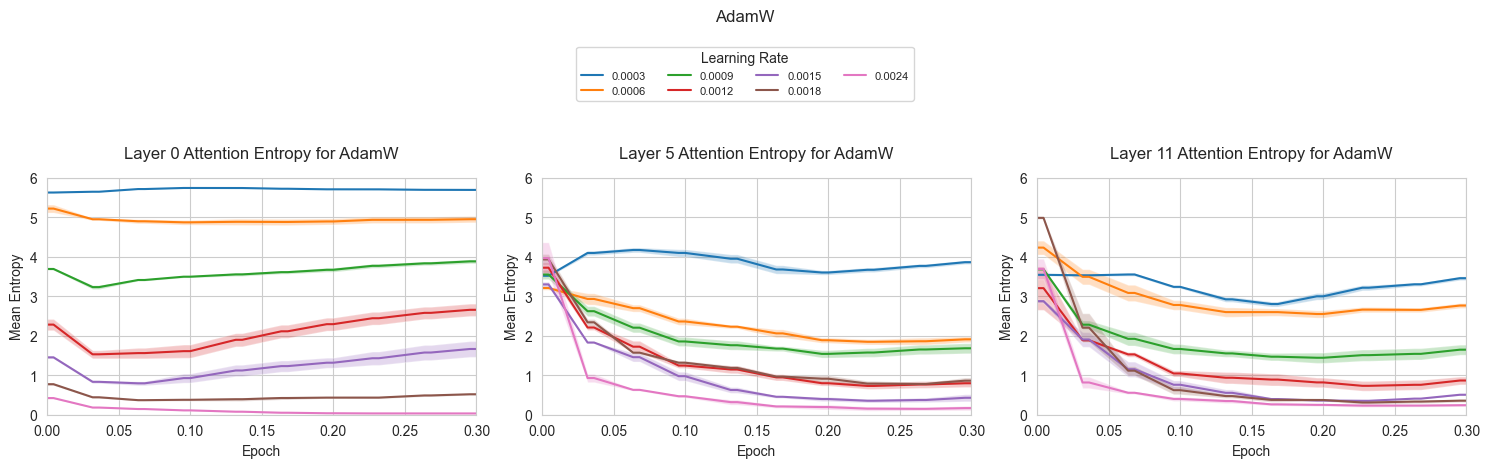

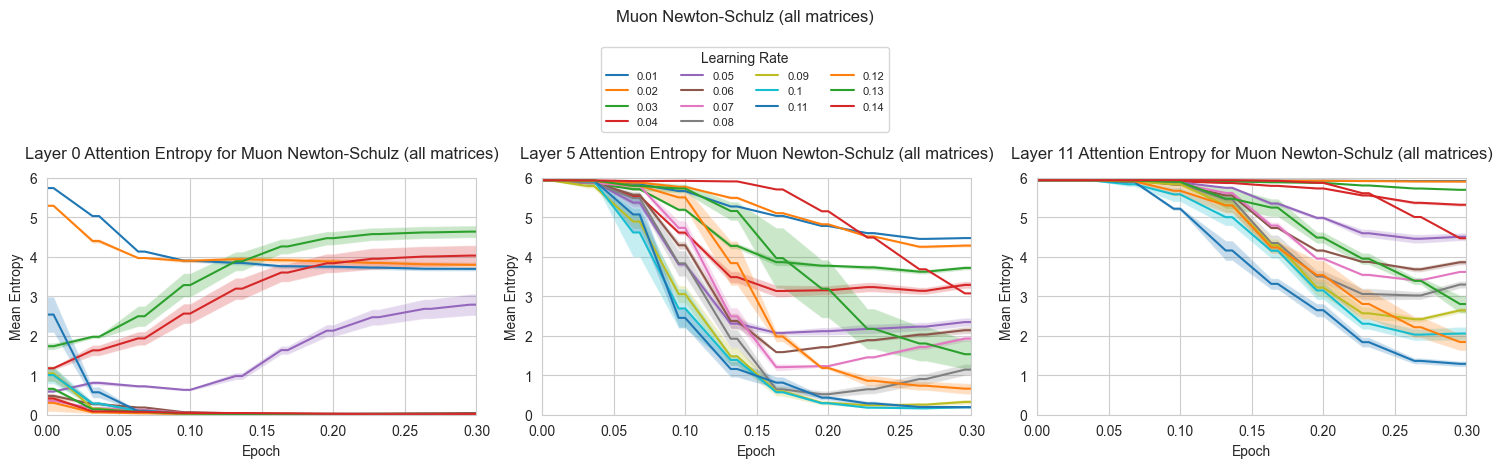

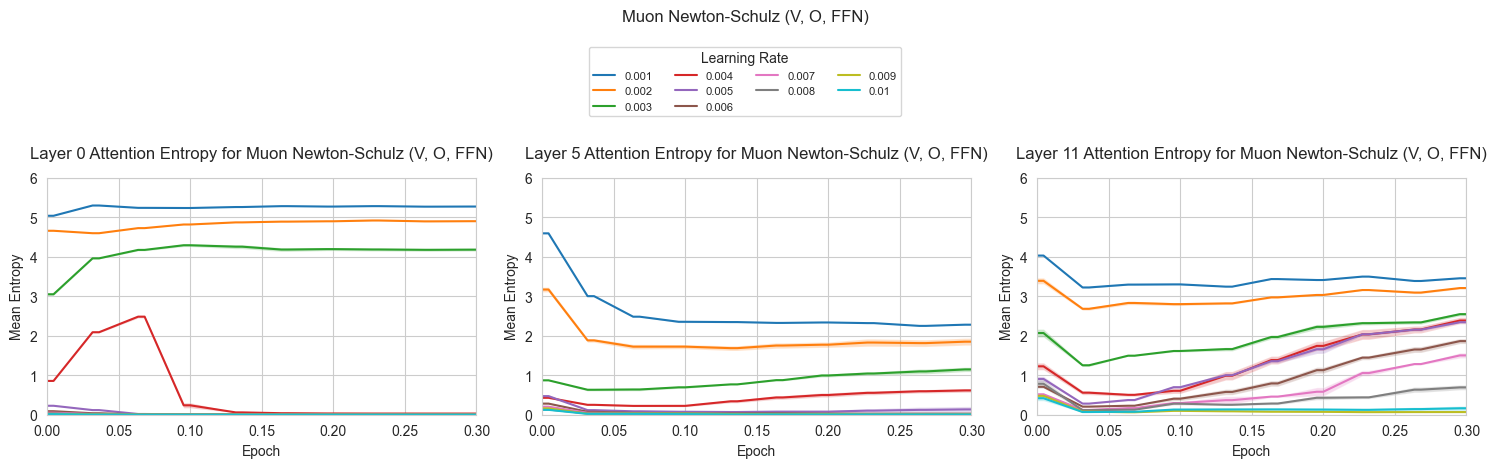

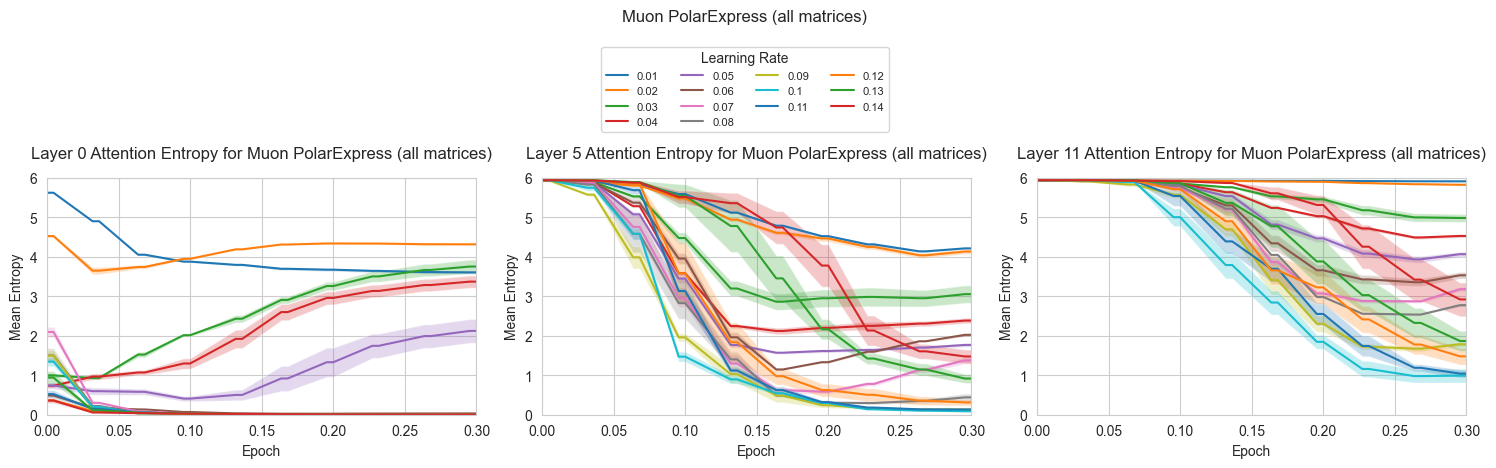

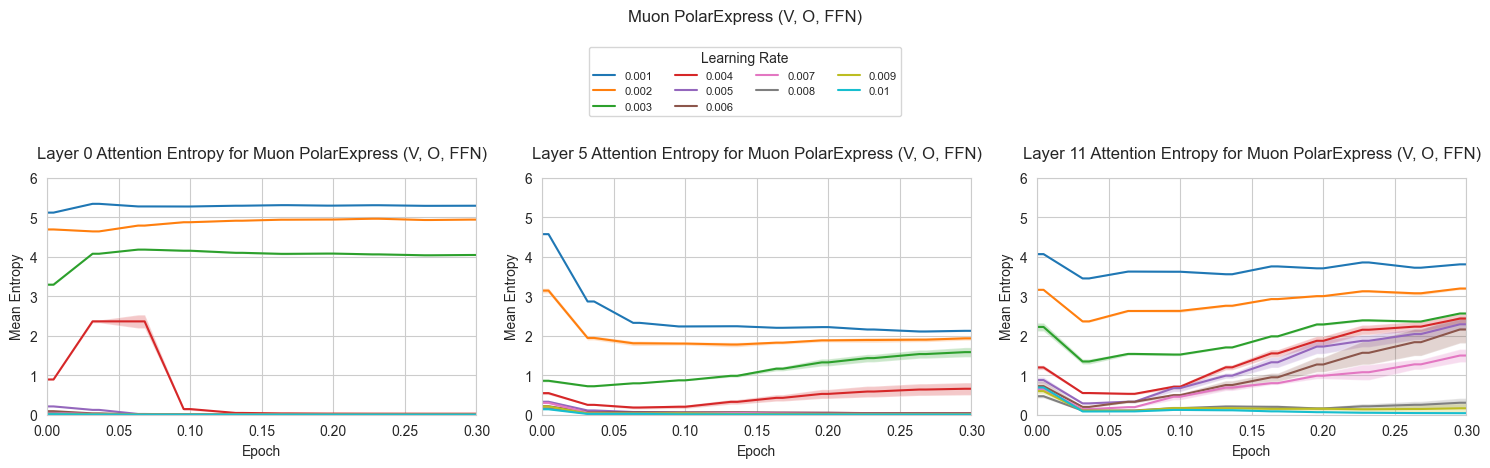

In [46]:
plot_all_layers(lr_min=0, lr_max=0.14, print_end_stats=False, use_cache=True)

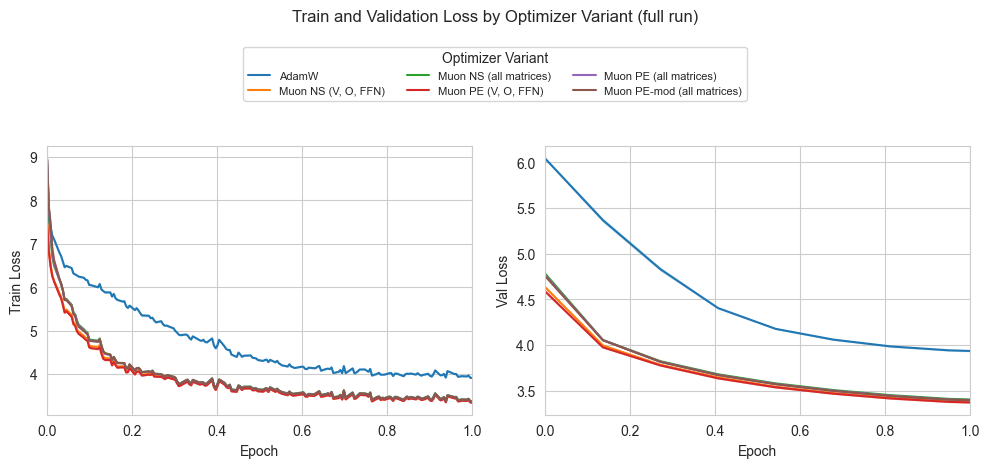

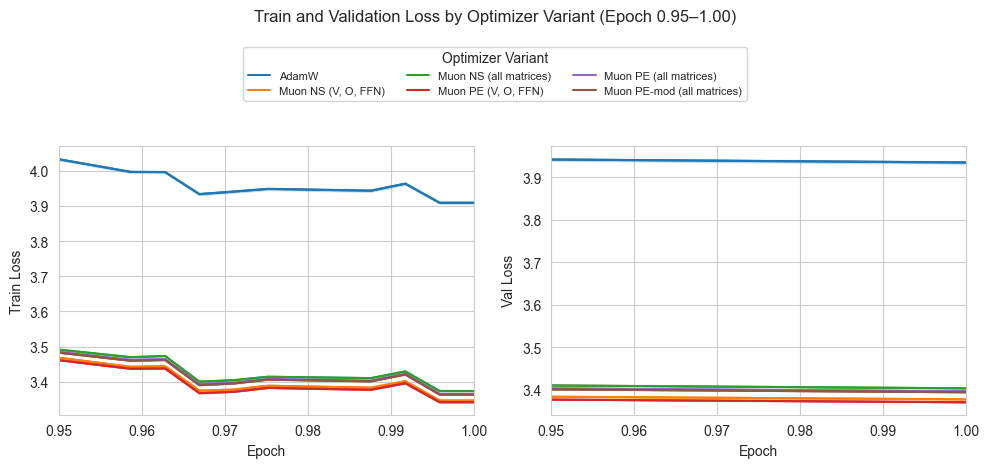

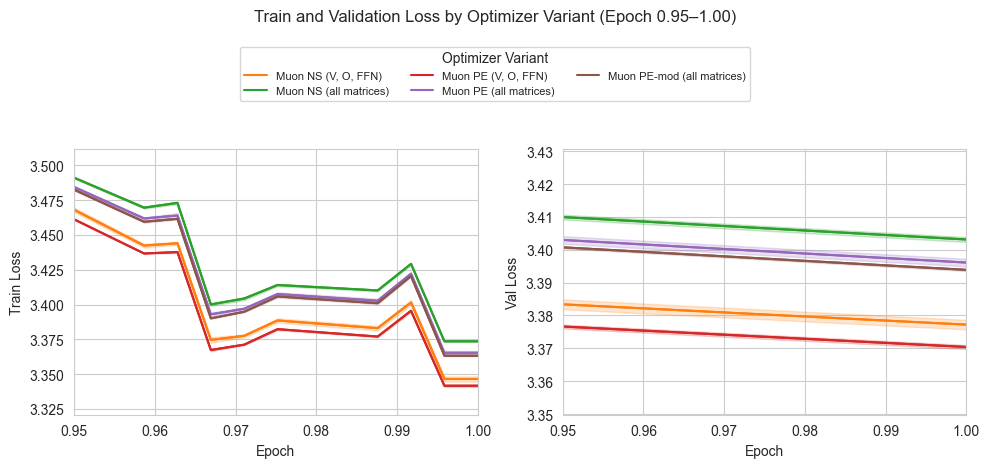

(<Figure size 1000x400 with 2 Axes>,
 array([<Axes: xlabel='Epoch', ylabel='Train Loss'>,
        <Axes: xlabel='Epoch', ylabel='Val Loss'>], dtype=object))

In [ ]:
plot_all_variants_from_sweeps(epoch_max=1.0)
plot_all_variants_from_sweeps(epoch_max=1.0,
                              epoch_window=(0.95, 1.0),
                              include_adamw=False)

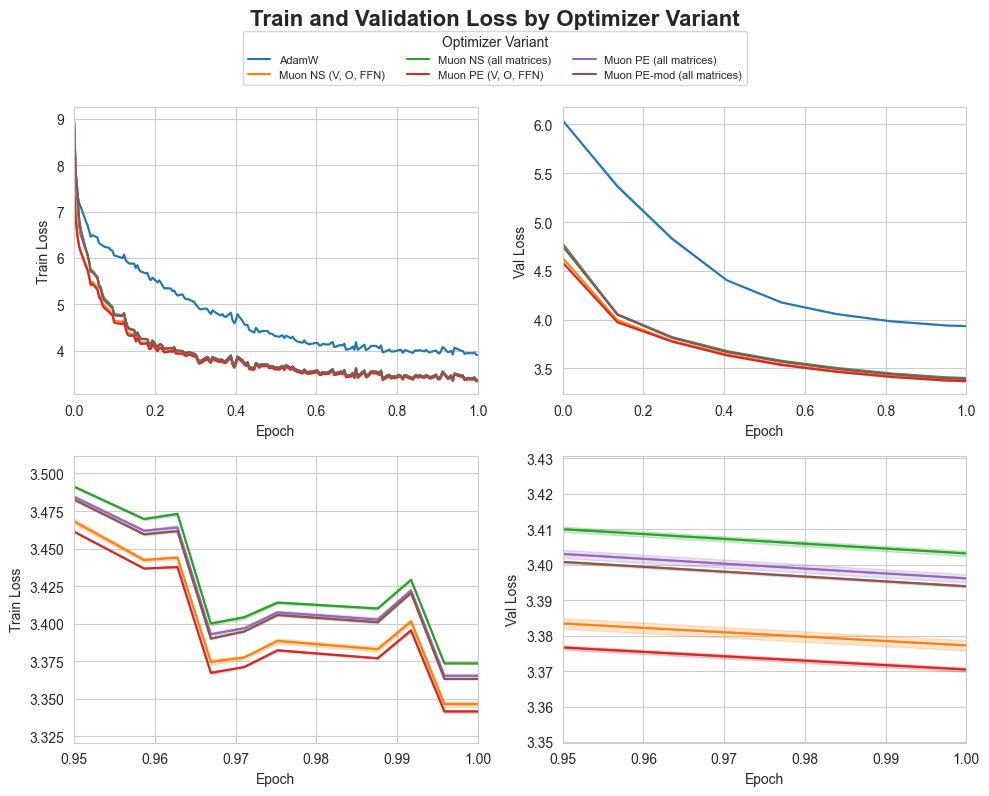

In [174]:
fig, axes = plot_full_and_zoomed_variants(
    sweep_ids=VARIANT_SWEEP_IDS,
    zoom_window=(0.95, 1.0),
    use_epoch_x=True,
    epoch_max=1.0,
    use_cache=True,
)

In [ ]:
# AdamW
plot_layers_for_category(
    "AdamW",
    layers=(0, 5, 11),
    lr_min=None, lr_max=None,
    print_end_stats=True,  # <- important
)

# Muon NS (All)
plot_layers_for_category(
    "Muon-NS-All",
    layers=(0, 5, 11),
    print_end_stats=True,
)

# Muon PE (All)
plot_layers_for_category(
    "Muon-PE-All",
    layers=(0, 5, 11),
    print_end_stats=True,
)

# Muon NS (VO+FFN)
plot_layers_for_category(
    "Muon-NS-VOFFN",
    layers=(0, 5, 11),
    print_end_stats=True,
)

# Muon PE (VO+FFN)
plot_layers_for_category(
    "Muon-PE-VOFFN",
    layers=(0, 5, 11),
    print_end_stats=True,
)

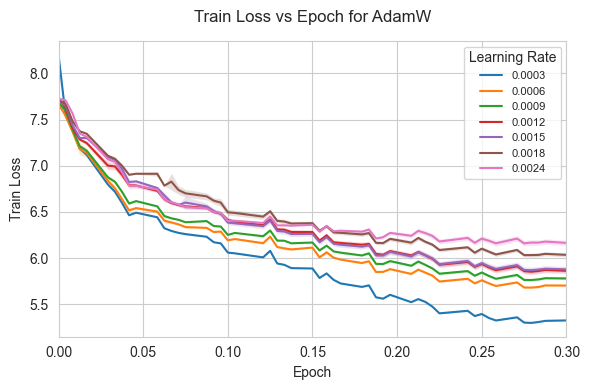

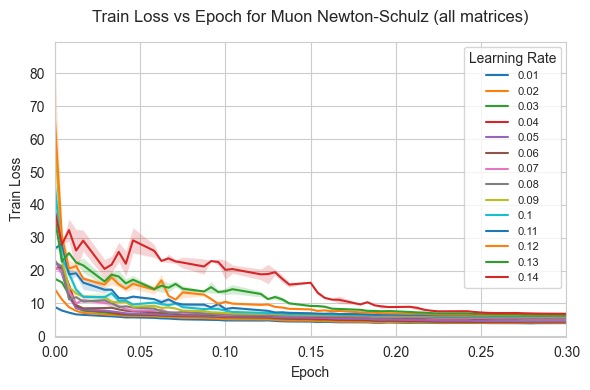

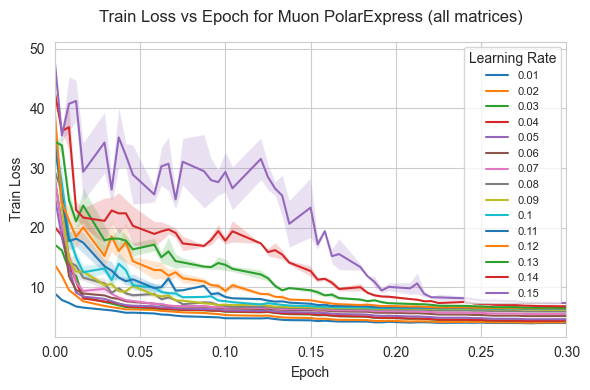

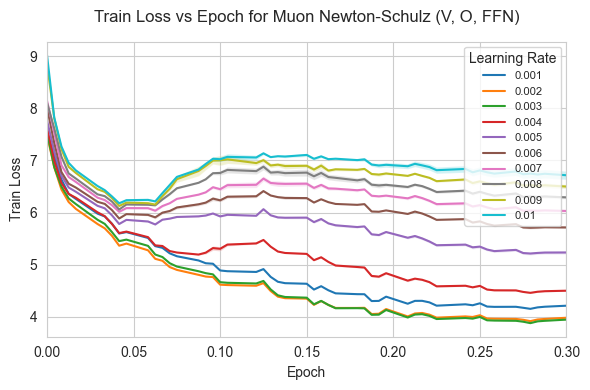

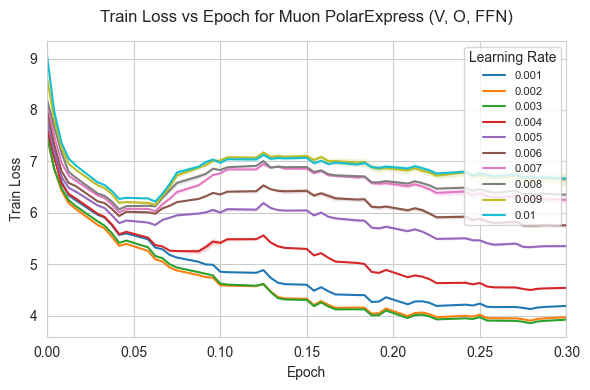

(<Figure size 600x400 with 1 Axes>,
 <Axes: title={'center': 'Train Loss vs Epoch for Muon PolarExpress (V, O, FFN)'}, xlabel='Epoch', ylabel='Train Loss'>)

In [41]:
# AdamW
plot_train_loss_for_attn_category("AdamW", lr_min=0.0003, lr_max=0.0024)

# Muon NS (All layers)
plot_train_loss_for_attn_category("Muon-NS-All", lr_min=0.01, lr_max=0.14)

# Muon PE (All layers)
plot_train_loss_for_attn_category("Muon-PE-All", lr_min=0.01, lr_max=0.15)

# Muon NS (V,O,FFN)
plot_train_loss_for_attn_category("Muon-NS-VOFFN", lr_min=0.001, lr_max=0.01)

# Muon PE (V,O,FFN)
plot_train_loss_for_attn_category("Muon-PE-VOFFN", lr_min=0.001, lr_max=0.01)

In [42]:
# Summarize final train loss by LR for AdamW + each Muon variant (attn sweeps)

attn_train_categories = [
    "AdamW",
    "Muon-NS-All",
    "Muon-PE-All",
    "Muon-NS-VOFFN",
    "Muon-PE-VOFFN",
]

for category_name in attn_train_categories:
    df = get_train_loss_for_attn_category(category_name)

    if df.empty:
        print(f"{category_name}: no train/loss data found.")
        continue

    # Take the last logged point per LR
    df_end = (
        df.sort_values("step")
          .groupby("lr")
          .tail(1)[["lr", "mean", "sem"]]
          .sort_values("lr")
    )

    print(f"\n=== {category_name} ===")
    for _, row in df_end.iterrows():
        lr = float(row["lr"])
        mean = float(row["mean"])
        sem = float(row["sem"])
        lower = mean - sem
        upper = mean + sem
        print(
            f"{category_name}, lr={lr:g}: "
            f"final train loss mean={mean:.4f}, lower={lower:.4f}, upper={upper:.4f}"
        )


=== AdamW ===
AdamW, lr=0.0003: final train loss mean=5.3265, lower=5.3222, upper=5.3308
AdamW, lr=0.0006: final train loss mean=5.7035, lower=5.6940, upper=5.7131
AdamW, lr=0.0009: final train loss mean=5.7807, lower=5.7665, upper=5.7948
AdamW, lr=0.0012: final train loss mean=5.8634, lower=5.8330, upper=5.8938
AdamW, lr=0.0015: final train loss mean=5.8786, lower=5.8463, upper=5.9110
AdamW, lr=0.0018: final train loss mean=6.0358, lower=6.0146, upper=6.0570
AdamW, lr=0.0024: final train loss mean=6.1651, lower=6.1353, upper=6.1948
AdamW, lr=0.0048: final train loss mean=6.3989, lower=6.3658, upper=6.4320
AdamW, lr=0.0192: final train loss mean=6.9208, lower=6.7458, upper=7.0958
AdamW, lr=0.0768: final train loss mean=7.4841, lower=7.3812, upper=7.5870

=== Muon-NS-All ===
Muon-NS-All, lr=0.01: final train loss mean=4.0069, lower=4.0064, upper=4.0074
Muon-NS-All, lr=0.02: final train loss mean=4.0904, lower=4.0893, upper=4.0916
Muon-NS-All, lr=0.03: final train loss mean=4.2584, lowe

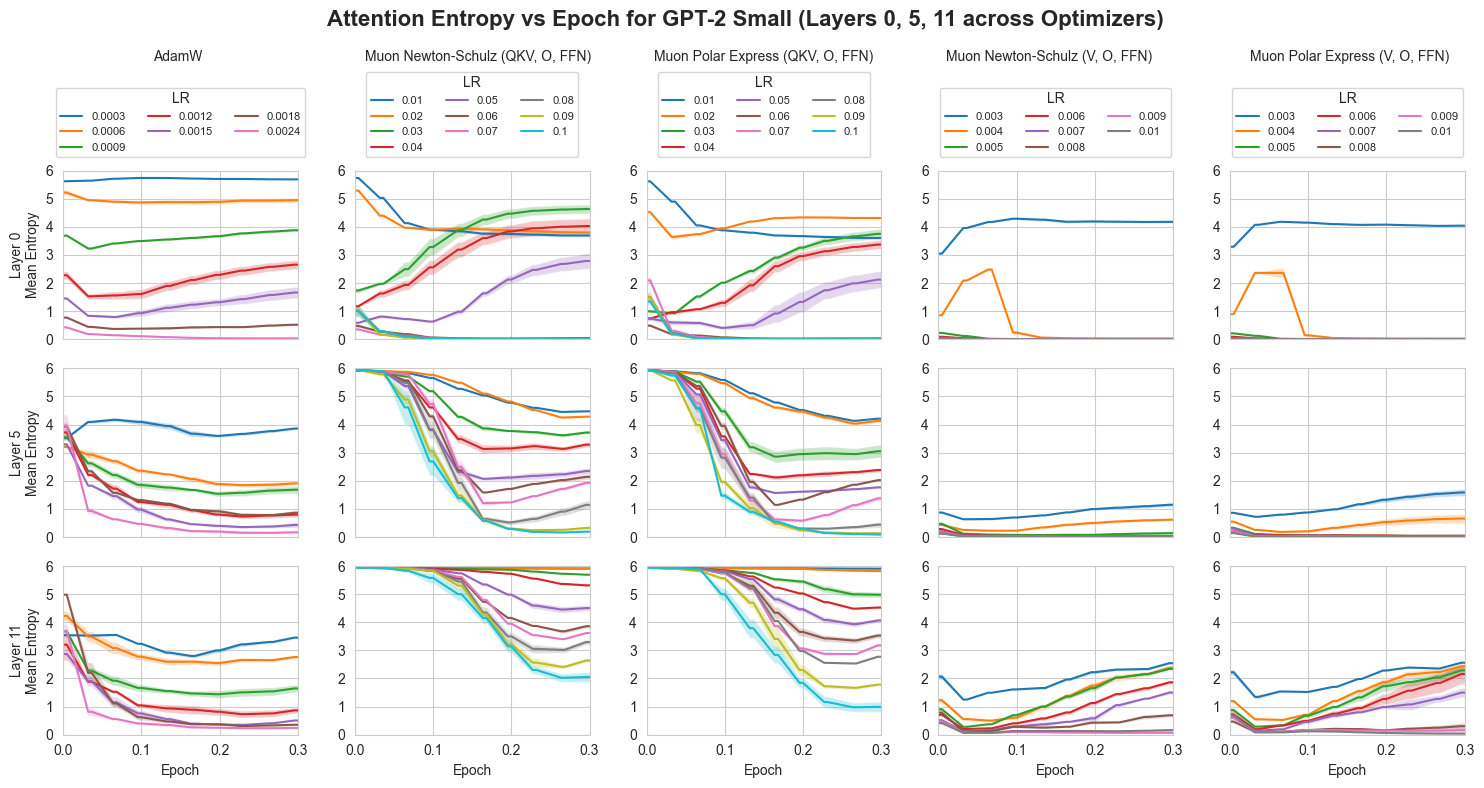

In [170]:
lr_ranges = {
    "AdamW": (0.0003, 0.0024),
    "Muon-NS-All": (0.01, 0.1),
    "Muon-PE-All": (0.01, 0.1),
    "Muon-NS-VOFFN": (0.003, 0.01),
    "Muon-PE-VOFFN": (0.003, 0.01),
}

base_lrs = {
    "AdamW": 0.0003,        # your chosen base LR for AdamW
    "Muon-NS-All": 0.01,    # example; set to your actual base
    "Muon-PE-All": 0.01,
    "Muon-NS-VOFFN": 0.003,
    "Muon-PE-VOFFN": 0.003,
}

fig, axes = plot_all_categories_combined(
    lr_ranges_by_category=lr_ranges,
    base_lr_by_category=base_lrs,
    print_end_stats=False,
)

In [175]:
# All AdamW attn-entropy runs
adamw_ids = ATTN_CATEGORIES["AdamW"]

df = get_attn_entropy_for_ids(adamw_ids, layer=0)  # any layer works for LR listing
sorted(df["lr"].unique())

[np.float64(0.0003),
 np.float64(0.0006),
 np.float64(0.0009),
 np.float64(0.0012),
 np.float64(0.0015),
 np.float64(0.0018),
 np.float64(0.0024),
 np.float64(0.0048),
 np.float64(0.0192),
 np.float64(0.021),
 np.float64(0.0768)]

In [176]:
api = wandb.Api()

ENTITY = "justin_yang-university-of-california-berkeley"
PROJECT = "cs182-project-GPT-opt"

# Try as sweep
try:
    sweep = api.sweep(f"{ENTITY}/{PROJECT}/w4yn5p1b")
    print("w4yn5p1b is a SWEEP; runs and LRs:")
    for r in sweep.runs:
        lr = r.config["optimizer_params"]["args"]["lr"]
        print(r.id, lr)
except Exception as e:
    print("Not a sweep:", e)

# Try as single run
try:
    run = api.run(f"{ENTITY}/{PROJECT}/w4yn5p1b")
    print("w4yn5p1b is a RUN; lr =", run.config["optimizer_params"]["args"]["lr"])
except Exception as e:
    print("Not a run:", e)

w4yn5p1b is a SWEEP; runs and LRs:
tqcf63b5 0.021
hlsqfm04 0.021
ocushj4g 0.021
Not a run: Could not find run <Run justin_yang-university-of-california-berkeley/cs182-project-GPT-opt/w4yn5p1b (not found)>


In [177]:
df_w = get_attn_entropy_for_ids(["w4yn5p1b"], layer=0)
print("Unique LRs seen in attn df:", sorted(df_w["lr"].unique()))
print("Has 0.0021?", 0.0021 in df_w["lr"].unique())

Unique LRs seen in attn df: [np.float64(0.021)]
Has 0.0021? False
